In [1]:
import os
import shutil
import random
from tqdm import tqdm

def split_dataset(base_dir, train_dir, val_dir, split_ratio=0.8):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))
               and d not in ['train', 'val']]

    for cls in tqdm(classes, desc="Splitting"):
        cls_path = os.path.join(base_dir, cls)
        images = os.listdir(cls_path)
        random.shuffle(images)

        split_idx = int(len(images) * split_ratio)
        train_imgs = images[:split_idx]
        val_imgs = images[split_idx:]

        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
        for img in val_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))

# 📁 분할 실행
base_path = r"C:\Users\ghwns\HJ_git\real-time-daily-activity-recognizer\images"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")

split_dataset(
    base_dir=base_path,
    train_dir=train_path,
    val_dir=val_path,
    split_ratio=0.8
)

Splitting: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/it]


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30

In [4]:
train_dir = r"C:\Users\ghwns\HJ_git\real-time-daily-activity-recognizer\images\train"
val_dir = r"C:\Users\ghwns\HJ_git\real-time-daily-activity-recognizer\images\val"

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 3066 images belonging to 8 classes.
Found 769 images belonging to 8 classes.


In [7]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [8]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/30


96/96 [==============================] - ETA: 0s - loss: 1.6262 - accuracy: 0.4077

C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 223s 2s/step - loss: 1.6262 - accuracy: 0.4077 - val_loss: 1.5644 - val_accuracy: 0.4213 - lr: 1.0000e-04
Epoch 2/30
96/96 [==============================] - 161s 2s/step - loss: 1.1193 - accuracy: 0.5828 - val_loss: 1.4432 - val_accuracy: 0.4668 - lr: 1.0000e-04
Epoch 3/30
96/96 [==============================] - 167s 2s/step - loss: 0.9574 - accuracy: 0.6435 - val_loss: 1.3060 - val_accuracy: 0.5319 - lr: 1.0000e-04
Epoch 4/30
96/96 [==============================] - 168s 2s/step - loss: 0.8729 - accuracy: 0.6755 - val_loss: 1.2650 - val_accuracy: 0.5345 - lr: 1.0000e-04
Epoch 5/30
96/96 [==============================] - 159s 2s/step - loss: 0.7900 - accuracy: 0.7100 - val_loss: 1.2552 - val_accuracy: 0.5449 - lr: 1.0000e-04
Epoch 6/30
96/96 [==============================] - 159s 2s/step - loss: 0.7378 - accuracy: 0.7361 - val_loss: 1.2230 - val_accuracy: 0.5475 - lr: 1.0000e-04
Epoch 7/30
96/96 [==============================] - 159s 2s/ste

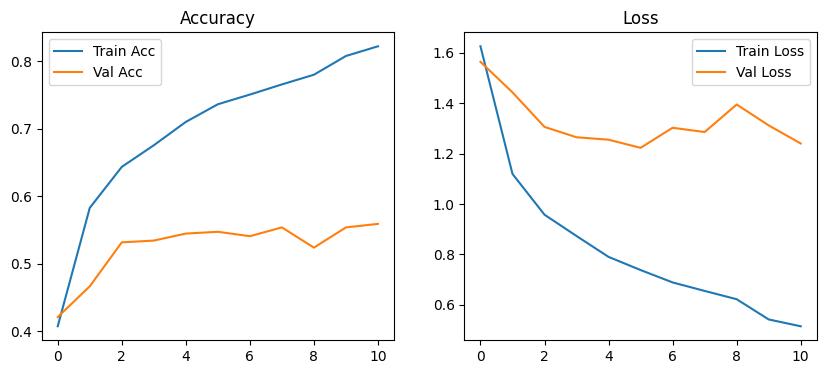

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

In [13]:
train_acc = max(history.history['accuracy'])
val_acc = max(history.history['val_accuracy'])

train_loss = min(history.history['loss'])
val_loss = min(history.history['val_loss'])

print(f"📊 Train Accuracy 최고: {train_acc:.4f}")
print(f"📊 Val Accuracy 최고:   {val_acc:.4f}")
print(f"📉 Train Loss 최저:     {train_loss:.4f}")
print(f"📉 Val Loss 최저:       {val_loss:.4f}")

📊 Train Accuracy 최고: 0.8219
📊 Val Accuracy 최고:   0.5592
📉 Train Loss 최저:     0.5145
📉 Val Loss 최저:       1.2230
